# Cosmology: Project 1.
_Prof. Alma Xóchitl González Morales_

**_By: Gabriel Missael Barco. 15/03/2022_**

## Point 1:
Find solutions for the scale factor a(t) using the cosmological parameters of the baseline cosmology, use it to express the Hubble factor H as function of t.

### General form:

$$\frac{H^2}{H_o^2} = \frac{\dot{a}^2}{a^2H_0^2} = \frac{\Omega_{r, 0}}{a^4} + \frac{\Omega_{m, 0}}{a^3} + \Omega_{\Lambda, 0} + \frac{1-\Omega_0}{a^2}$$

The benchmark model has $\Omega_0 = 1$, then we have:

$$\implies \dot{a} = H_0\sqrt{\frac{\Omega_{r, 0}}{a^2} + \frac{\Omega_{m, 0}}{a} + \Omega_{\Lambda, 0}a^2}$$

In [1]:
# Import the necessary packages

import numpy as np  # Package for scientific computing with Python
import matplotlib.pyplot as plt  # Package for plotting
import pandas as pd  # Package for data analysis
import seaborn as sns  # Package for plotting styles
import matplotlib as mlp  # Package for plotting

sns.set_theme()

# Improve image resolution
mlp.rcParams['figure.dpi'] = 100

In [2]:
# Important constants
c = 299792.458 # Units: km/s
G = 4.302e-9 # Units: km^2 Mpc^-3 Msun^-1 s^-2

# Cosmological parameters from Planck 2015 results
H_0 = 67.36 # Units: km/s/Mpc
Omega_m = 0.3111 # Matter density
Omega_l = 0.6889 # Dark energy density
Omega_r = 4.165e-5 # Radiation density

In [3]:
def get_a_dot(a, omega_m = Omega_m, omega_l = Omega_l, omega_r = Omega_r, equality = False):
    """
    Function to get the derivative of the expansion factor, considering the types of matter.

    INPUT:
        a: expansion factor
        radiation: if True, include radiation
        matter: if True, include matter
        dark: if True, include dark energy
    OUTPUT:
        a_dot: derivative of the expansion factor
    """
    # Contribution from different types of matter
    a_m = omega_m/a
    a_r = omega_r/(a**2)
    a_l = omega_l*(a**2)
    a_dot = a_m + a_l + a_r

    # Check for equality
    if equality:
        if np.abs(a_m - a_l) < 0.0001 and a_m != 0 and a_l != 0:
            print('Matter and dark matter equality at a = ', a)
        if np.abs(a_m - a_r) < 0.0001 and a_m != 0 and a_r != 0:
            print('Matter and radiation equality at a = ', a)
        if np.abs(a_l - a_r) < 0.0001 and a_l != 0 and a_r != 0:
            print('Dark matter and radiation equality at a = ', a)

    # Not negative values allowed
    if a_dot <0:
        print('Negative derivative at a = ', a)
        return 0

    # Return the derivative
    a_dot = H_0 * np.sqrt(a_dot)
    return a_dot

In [4]:
def runge_kutta(f, y_0, t0 = 0, h = -0.001, omega_m = Omega_m,
                omega_l = Omega_l, omega_r = Omega_r, return_densities = False, n_max = 100000):
    """
    Function to solve a system of differential equations using the Runge-Kutta method (order 4).

    INPUT:
        f: function to solve
        t0: initial time
        y_0: initial value
        h: step
    OUTPUT:
        t: time
        y: solution
    """
    # Initialize list to store densities
    matter, radiation, dark = [omega_m], [omega_r], [omega_l]

    # Initialize list to store a derivatives
    a_dot = [get_a_dot(y_0, omega_m = omega_m, omega_l = omega_l, omega_r = omega_r)]

    # Initialize list to store time and a.
    y = [y_0]
    t = [t0]

    # Loop to solve the system of differential equations
    while True:
        # Runge-Kutta coefficients
        k1 = f(y[-1], omega_m = omega_m, omega_l = omega_l, omega_r = omega_r)
        k2 = f(y[-1] + k1*h/2, omega_m = omega_m, omega_l = omega_l, omega_r = omega_r)
        k3 = f(y[-1] + k2*h/2, omega_m = omega_m, omega_l = omega_l, omega_r = omega_r)
        k4 = f(y[-1] + k3*h, omega_m = omega_m, omega_l = omega_l, omega_r = omega_r)

        # Update time and solution
        y_aux = y[-1] + (k1 + 2*k2 + 2*k3 + k4)*h/6
        t_aux = t[-1] + h

        # Maximum number of iterations
        if len(y) > n_max:
            break

        # Only allow positive a and lower than 20
        if (h < 0 and y_aux > 0) or (h > 0 and y_aux < 20):
                y.append(y_aux)
                t.append(t_aux)

                # If return_densities is True, store the densities
                if return_densities:
                    # Store the derivatives
                    y_dot = f(y_aux, omega_m = omega_m, omega_l = omega_l, omega_r = omega_r)

                    # Compute H_0/H
                    constant = H_0**2/(y_dot/y_aux)**2

                    # Store the densities
                    a_dot.append(y_dot)
                    matter.append(omega_m/(y_aux**3)*constant)
                    radiation.append(omega_r/(y_aux**4)*constant)
                    dark.append(omega_l*constant)
        else:
            break
    if return_densities:
        return t, y, matter, radiation, dark, a_dot
    else:
        return t, y

In [5]:
h = 0.001 # Step
t0 = 1 # Initial time

# Universe only with matter
x_m, y_m = runge_kutta(f = get_a_dot, y_0 = 1,t0 = t0, h = h,
                    omega_m = 1.0, omega_l = 0.0, omega_r = 0.0) # Future expansion factor
x_aux, y_aux = runge_kutta(f = get_a_dot, y_0 = 1, t0 =  t0, h = -0.0001,
                    omega_m = 1.0, omega_l = 0.0, omega_r = 0.0) # Past expansion factor
# Merge the two lists
x_m = x_aux[::-1] + x_m
y_m = y_aux[::-1] + y_m

# Universe only with radiation
x_r, y_r = runge_kutta(f = get_a_dot, y_0 = 1, t0 =  t0, h = h, omega_m = 0.0, omega_l = 0.0, omega_r = 1.0)
x_aux, y_aux = runge_kutta(f = get_a_dot, y_0 = 1, t0 =  t0, h = -0.0001, omega_m = 0.0, omega_l = 0.0, omega_r = 1.0)
x_r = x_aux[::-1] + x_r
y_r = y_aux[::-1] + y_r

# Universe only with dark matter
x_l, y_l = runge_kutta(f = get_a_dot, y_0 = 1, t0 =  t0, h = h, omega_m = 0.0, omega_l = 1.0, omega_r = 0.0)
x_aux, y_aux = runge_kutta(f = get_a_dot, y_0 = 1, t0 = t0, h = -h, omega_m = 0.0, omega_l = 1.0, omega_r = 0.0)
x_l = x_aux[::-1] + x_l
y_l = y_aux[::-1] + y_l

/tmp/ipykernel_543/3429811448.py:15: RuntimeWarning: invalid value encountered in double_scalars
  a_r = omega_r/(a**2)


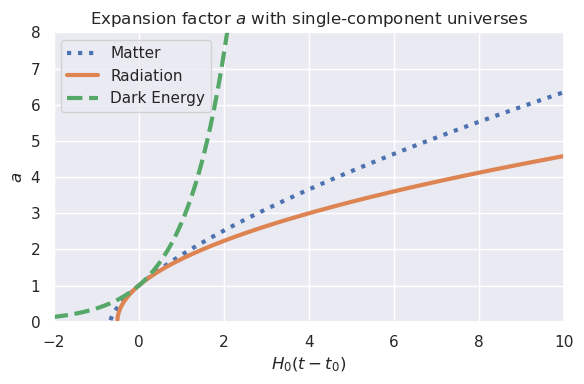

In [6]:
# Plot of single-component universes

fig, ax = plt.subplots(figsize = (6, 4))

ax.plot((np.array(x_m)-t0)*H_0, y_m, label = 'Matter', linestyle = 'dotted', linewidth = 3)
ax.plot((np.array(x_r)-t0)*H_0, y_r, label = 'Radiation', linestyle = 'solid', linewidth = 3)
ax.plot((np.array(x_l)-t0)*H_0, y_l, label = 'Dark Energy', linestyle = 'dashed', linewidth = 3)

ax.set_ylim(0, 8)
ax.set_xlim(-2, 10)
ax.set_xlabel('$H_0(t-t_0)$')
ax.set_ylabel('$a$')
ax.set_title('Expansion factor $a$ with single-component universes')
ax.legend()
plt.tight_layout()
plt.savefig('./figs/single_component_universe.png', dpi = 300)
plt.show()
plt.close(fig)

In [7]:
# Simulate benchmark universe model (three components)

t0 = 0
x_b, y_b = runge_kutta(f = get_a_dot, y_0 = 1, t0 = t0, h = 0.0000001, n_max = 1000000)
x_aux, y_aux = runge_kutta(f = get_a_dot, y_0 = 1, t0 = t0, h = -0.0000001, n_max = 1000000)
x_b = x_aux[::-1] + x_b
y_b = y_aux[::-1] + y_b

In [8]:
# Matter-Dark matter equality at 0.7672
idx_ml = np.where(np.abs(np.array(y_b) - 0.76725) < 0.0001)[0][0]
print(x_b[idx_ml], y_b[idx_ml])

# Radiation-Matter (acording to the book) at 2.9e-4
idx_rm = np.where(np.abs(np.array(y_b) - 2.9e-4) < 1)[0][0]
print(x_b[idx_rm], y_b[idx_rm])

-0.003658699999997579 0.7671549583080319
-0.01416469999997014 0.00035275320459171697


/tmp/ipykernel_543/3747719866.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log((np.array(x_b)-min(x_b))*H_0), np.log(y_b), label = 'Benchmark', linestyle = 'solid', linewidth = 2, alpha = 0.8)


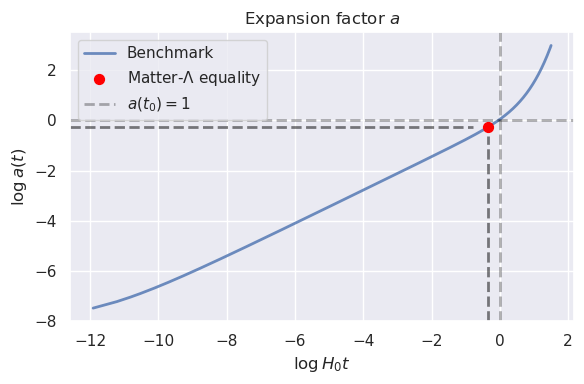

In [9]:
# Benchmark model plot (log scale)
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(np.log((np.array(x_b)-min(x_b))*H_0), np.log(y_b), label = 'Benchmark', linestyle = 'solid', linewidth = 2, alpha = 0.8)

# Matter-Dark matter equality at 0.7672
x_ml = np.log((np.array(x_b[idx_ml])-min(x_b))*H_0)
y_ml = np.log(y_b[idx_ml])
ax.scatter(x_ml, y_ml, color = 'red', label = 'Matter-$\Lambda$ equality', marker = 'o', s = 50, zorder= 100)
ax.axhline(y = y_ml, color = 'black', linestyle = 'dashed', linewidth = 2, alpha = 0.5, xmin = 0, xmax = 0.8)
ax.axvline(x = x_ml, color = 'black', linestyle = 'dashed', linewidth = 2, alpha = 0.5, ymax = 0.64)

# Today
ax.axhline(y = 0, color = 'black', linestyle = 'dashed', alpha = 0.3, linewidth = 2)
ax.axvline(x = 0, color = 'black', linestyle = 'dashed', alpha = 0.3, linewidth = 2, label = '$a(t_0) = 1$')

ax.set_xlabel('$\log{H_0t}$')
ax.set_ylabel('$\log{a(t)}$')
ax.set_title('Expansion factor $a$')
ax.legend()

plt.tight_layout()
plt.savefig('./figs/benchmark_universe_log.png', dpi = 300)
plt.show()
plt.close(fig)

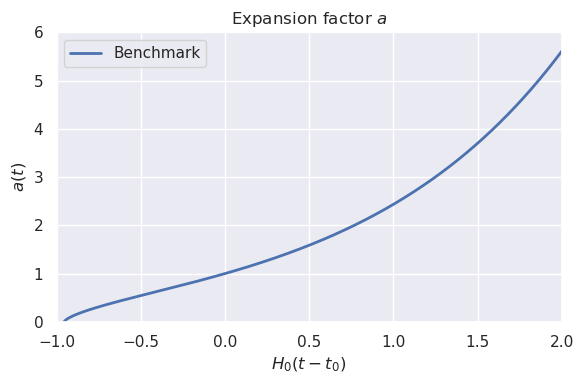

In [10]:
# Benchmark model plot (linear scale)
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot((np.array(x_b)-t0)*H_0, y_b, label = 'Benchmark', linestyle = 'solid', linewidth = 2)

ax.set_xlabel('$H_0(t-t_0)$')
ax.set_ylabel('$a(t)$')
ax.set_ylim(0, 6)
ax.set_xlim(-1, 2)
ax.set_title('Expansion factor $a$')
ax.legend()

plt.tight_layout()
plt.savefig('./figs/benchmark_universe.png', dpi = 300)
plt.show()
plt.close(fig)

## Point 2:

Make plots of how the energy density of the different matter-energy species
evolves as function of a, z and t.

We know how to calculate the energy density of the different matter-energy species. We also know, from the previous point, how the scale factor changes as a function of time. We will use the benchmark model to calculate the energy density of the different matter-energy species as a function of time.

The relationship between the energy density of radiation with respect to the scale factor a is given by:

$$\varepsilon_r = \frac{\varepsilon_{r, 0}}{a^4} \quad;\quad \Omega_r = \frac{\varepsilon_r}{\varepsilon_c} \quad;\quad \varepsilon_c = \frac{3c^2}{8\pi G}(\frac{\dot{a}}{a})^2$$

$$\implies \Omega_r = \frac{\Omega_{r, 0}\varepsilon_{c, 0}}{a^4\varepsilon_c} \implies \Omega_r = \frac{\Omega_{r, 0}}{a^4}\frac{H_0^2}{H^2}$$

Analogously, the energy density of matter and dark energy is given by:

$$\Omega_m = \frac{\Omega_{m, 0}}{a^3}\frac{H_0^2}{H^2} \quad;\quad \Omega_\Lambda = \Omega_{\Lambda, 0}\frac{H_0^2}{H^2}$$

In [11]:
# Benchmark model with densities
t0 = 0
x_b, y_b, matter, radiation, dark, a_dot  = runge_kutta(f = get_a_dot, y_0 = 1,
            t0 = t0, h = 0.0000001, return_densities=True, n_max = 1000000)
x_aux, y_aux, matter_aux, radiation_aux, dark_aux, a_dot_aux = runge_kutta(f = get_a_dot, y_0 = 1, t0 = t0,
            h = -0.00000001, return_densities=True, n_max = 10000000)

x_b = x_aux[::-1] + x_b
y_b = y_aux[::-1] + y_b
matter = matter_aux[::-1] + matter
radiation = radiation_aux[::-1] + radiation
dark = dark_aux[::-1] + dark
a_dot = a_dot_aux[::-1] + a_dot

In [12]:
# Create DataFrame with full simulation
df = pd.DataFrame(data = {'t': (np.array(x_b)-t0)*H_0, 'a': y_b, 'matter density': matter,
                'radiation density': radiation, 'dark density': dark, 'a_dot': a_dot})

# Data example
df.head(5)

,t,a,matter density,radiation density,dark density,a_dot
0,-0.954140,0.000093,0.409850,0.590150,7.294826e-13,6086.261121
1,-0.954139,0.000144,0.517432,0.482568,3.389521e-12,4359.339198
2,-0.954138,0.000183,0.577814,0.422186,7.871165e-12,3651.396884
3,-0.954138,0.000218,0.619015,0.380985,1.410864e-11,3237.775637
4,-0.954137,0.000248,0.649805,0.350195,2.205987e-11,2957.104080


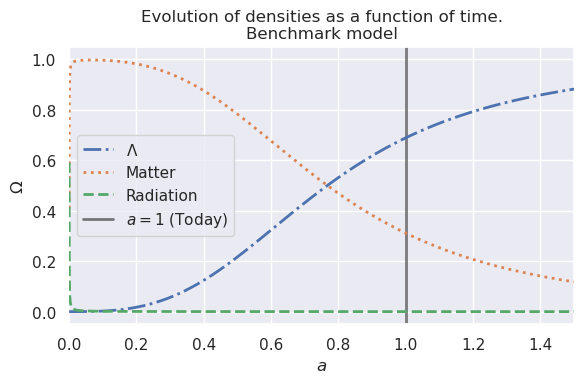

In [13]:
# Densities evolution as a function of the scale factor
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(df['a'], df['dark density'], label = '$\Lambda$', linestyle = 'dashdot', linewidth = 2,  zorder = 100)
ax.plot(df['a'], df['matter density'], label = 'Matter', linestyle = 'dotted', linewidth = 2,  zorder = 100)
ax.plot(df['a'], df['radiation density'], label = 'Radiation', linestyle = 'dashed', linewidth = 2,  zorder = 100)

ax.axvline(x = 1, color = 'black', linestyle = 'solid', linewidth = 2, alpha = 0.5, label = '$a = 1$ (Today)', zorder = 1)
ax.set_xlabel('$a$')
ax.set_ylabel('$\Omega$')
ax.set_title('Evolution of densities as a function of time.\nBenchmark model')
ax.set_xlim(0, 1.5)
plt.legend(loc = 'best')

plt.tight_layout()
plt.savefig('./figs/densities_evolution_a.png', dpi = 300)
plt.show()
plt.close(fig)

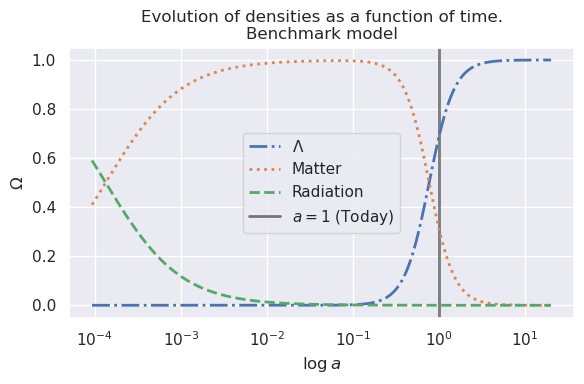

In [14]:
# Densities evolution as a function of the scale factor (log scale)
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(df['a'], df['dark density'], label = '$\Lambda$', linestyle = 'dashdot', linewidth = 2,  zorder = 100)
ax.plot(df['a'], df['matter density'], label = 'Matter', linestyle = 'dotted', linewidth = 2,  zorder = 100)
ax.plot(df['a'], df['radiation density'], label = 'Radiation', linestyle = 'dashed', linewidth = 2,  zorder = 100)

ax.axvline(x = 1, color = 'black', linestyle = 'solid', linewidth = 2, alpha = 0.5, label = '$a = 1$ (Today)', zorder = 1)
ax.set_xlabel('$\log{a}$')
ax.set_ylabel('$\Omega$')
ax.set_title('Evolution of densities as a function of time.\nBenchmark model')

# X-scale to log scale
plt.xscale('log')
plt.legend(loc = 'center')

plt.tight_layout()
plt.savefig('./figs/densities_evolution_loga.png', dpi = 300)
plt.show()
plt.close(fig)

The redshift is related with the scale factor as:

$$1 + z = \frac{1}{a(t)}$$

With $a(t_{obs}) = 1$.

In [15]:
# Get redshift for every expansion factor
df['z'] = 1/df['a'] - 1

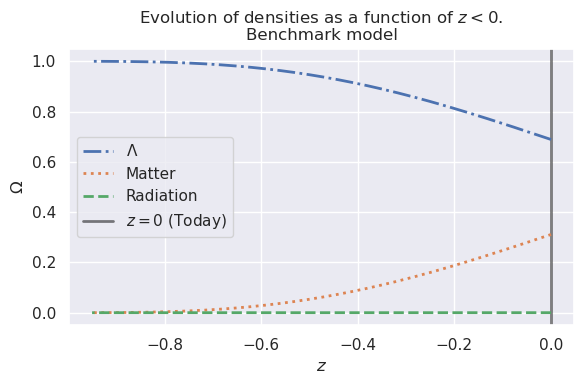

In [16]:
# Denisties evolution as a function of redshift (z<0 - Future)
fig, ax = plt.subplots(figsize = (6, 4))

df_future = df[df['z'] < 0]
df_past = df[df['z'] > 0.01]

ax.plot(df_future['z'], df_future['dark density'], label = '$\Lambda$', linestyle = 'dashdot', linewidth = 2,  zorder = 100)
ax.plot(df_future['z'], df_future['matter density'], label = 'Matter', linestyle = 'dotted', linewidth = 2,  zorder = 100)
ax.plot(df_future['z'], df_future['radiation density'], label = 'Radiation', linestyle = 'dashed', linewidth = 2,  zorder = 100)

ax.axvline(x = 0, color = 'black', linestyle = 'solid', linewidth = 2, alpha = 0.5, label = '$z = 0$ (Today)', zorder = 1)
ax.set_xlabel('$z$')
ax.set_ylabel('$\Omega$')
ax.set_title('Evolution of densities as a function of $z<0$.\nBenchmark model')

plt.legend(loc = 'best')

plt.tight_layout()
plt.savefig('./figs/densities_evolution_z_future.png', dpi = 300)
plt.show()
plt.close(fig)

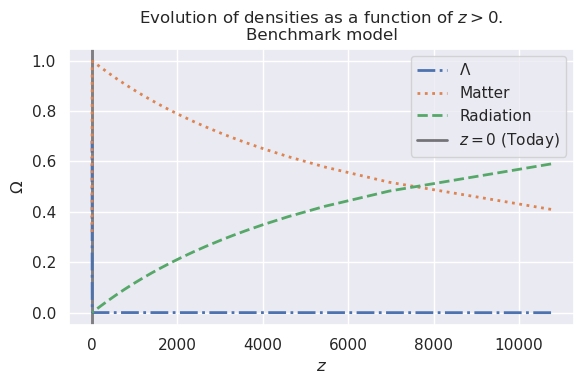

In [17]:
# Denisties evolution as a function of redshift (z>0 - past)
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(df_past['z'], df_past['dark density'], label = '$\Lambda$', linestyle = 'dashdot', linewidth = 2,  zorder = 100)
ax.plot(df_past['z'], df_past['matter density'], label = 'Matter', linestyle = 'dotted', linewidth = 2,  zorder = 100)
ax.plot(df_past['z'], df_past['radiation density'], label = 'Radiation', linestyle = 'dashed', linewidth = 2,  zorder = 100)

ax.axvline(x = 0, color = 'black', linestyle = 'solid', linewidth = 2, alpha = 0.5, label = '$z = 0$ (Today)', zorder = 1)
ax.set_xlabel('$z$')
ax.set_ylabel('$\Omega$')
ax.set_title('Evolution of densities as a function of $z>0$.\nBenchmark model')

plt.legend(loc = 'best')

plt.tight_layout()
plt.savefig('./figs/densities_evolution_z_future.png', dpi = 300)
plt.show()
plt.close(fig)

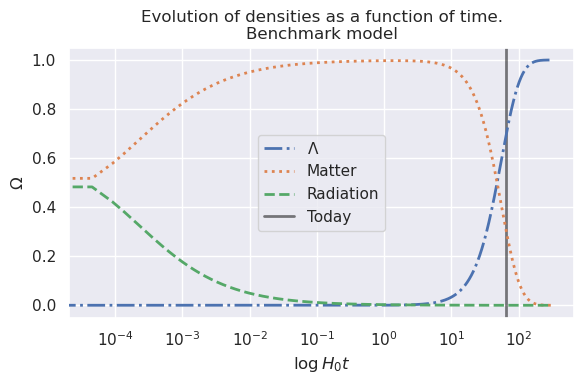

In [18]:
# Densities evolution as a function of time (log scale)
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot((df['t']-min(df['t']))*H_0, df['dark density'], label = '$\Lambda$', linestyle = 'dashdot', linewidth = 2,  zorder = 100)
ax.plot((df['t']-min(df['t']))*H_0, df['matter density'], label = 'Matter', linestyle = 'dotted', linewidth = 2,  zorder = 100)
ax.plot((df['t']-min(df['t']))*H_0, df['radiation density'], label = 'Radiation', linestyle = 'dashed', linewidth = 2,  zorder = 100)

ax.axvline(x = (-min(df['t']))*H_0, color = 'black', linestyle = 'solid', linewidth = 2, alpha = 0.5, label = 'Today', zorder = 1)
ax.set_xlabel('$\log{H_0t}$')
ax.set_ylabel('$\Omega$')
ax.set_title('Evolution of densities as a function of time.\nBenchmark model')

# X-scale to exponential
plt.xscale('log')
plt.legend(loc = 'best')

plt.tight_layout()
plt.savefig('./figs/densities_evolution_logt.png', dpi = 300)
plt.show()
plt.close(fig)

In [19]:
# The time of the universe as predicted by the benchmark model
# APROXIMATION
time = (-min(df['t']))*H_0  # Units: km/s/Mpc

# Remove km and Mpc from time
time = 1/(time*(3.2478e-20))/31536000/1e9  # Units: Gyr
print('Time in Gyr: ', time)

Time in Gyr:  15.191131561951128


## Point 3

Compute the proper, the luminosity and angular-diameter distance. Make plots of such quantities for the base cosmology, and for variations of it. You can get some inspiration by the plots in chapter 5 and 6 of the Barbara Ryden book[2]. 

We are going to use the benchmark model to calculate the proper, the luminosity and angular-diameter distance, and we will plot the distance as a function of redshift. For our benchmark model, with $k = 0$, we have:

### Proper distance.
$$d_p(t_0) = c\int_{t_e}^{t_0}\frac{dt}{a(t)} \quad;\quad H = \frac{\dot{a}}{a} \implies \frac{da}{dt} = aH \implies dt = \frac{da}{aH}$$
$$\implies d_p = c\int_a^1\frac{1}{a}\frac{da}{aH} = c\int_a^1\frac{da}{a\dot{a}}$$

### Luminosity distance.

$$d_L = d_p(1+z)$$

### Angular diameter distance.

$$d_A = \frac{d_L}{(1+z)^2}$$

In [20]:
# Filter only positive redshifts of benchmark model
df_distance = df[df['z'] > 0.0]
df_distance.head(5)

,t,a,matter density,radiation density,dark density,a_dot,z
0,-0.954140,0.000093,0.409850,0.590150,7.294826e-13,6086.261121,10754.290258
1,-0.954139,0.000144,0.517432,0.482568,3.389521e-12,4359.339198,6965.110766
2,-0.954138,0.000183,0.577814,0.422186,7.871165e-12,3651.396884,5456.598931
3,-0.954138,0.000218,0.619015,0.380985,1.410864e-11,3237.775637,4596.172906
4,-0.954137,0.000248,0.649805,0.350195,2.205987e-11,2957.104080,4024.427866


In [21]:
def proper_distance(df):
    """
    Function to calculate the proper distance of a given simulation.
    INPUT:
    - df: DataFrame of a simulation
    OUTPUT:
    - dp: List wit proper distance of the simulation
    """
    # List for proper distance
    d_p = [0]
    n = len(df)

    # Iterate over values in dataframe (a, a_dot)
    for i in range(1, len(df)):
        delta_a = (df['a'][n-i]-df['a'][n-i-1]) # Psudo-differential
        d_p.append(d_p[-1] + delta_a/(df['a'][n-i]*df['a_dot'][n-i])) # Proper distance

    # Return list
    return np.array(d_p[::-1])*H_0 # Adjust units to Hubble distance

In [22]:
# Get proper distance of three simulations (dark, matter, benchmark)
df_distance['d_p'] = proper_distance(df_distance)

/tmp/ipykernel_543/3701085558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distance['d_p'] = proper_distance(df_distance)


In [23]:
# Filter out high redshifts
df_distance = df_distance[(df_distance['z'] > 0.01) & (df_distance['z'] < 1000)]

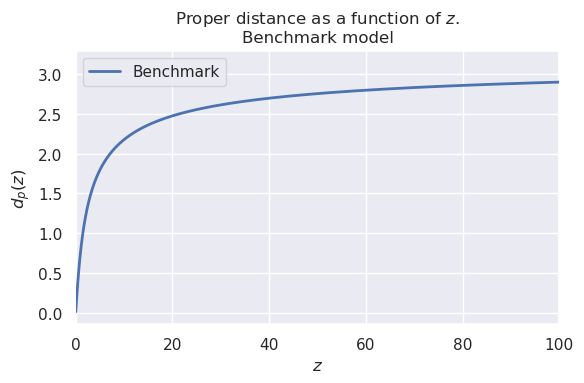

In [24]:
# Proper distance evolution as a function of redshift
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(df_distance['z'], df_distance['d_p'], label = 'Benchmark', linestyle = 'solid', linewidth = 2,  zorder = 100)
ax.set_xlabel('$z$')
ax.set_ylabel('$d_p(z)$')
ax.set_title('Proper distance as a function of $z$.\nBenchmark model')
ax.set_xlim(0, 100)
ax.legend()

plt.tight_layout()
plt.savefig('./figs/proper_distance_z.png', dpi = 300)
plt.show()
plt.close(fig)

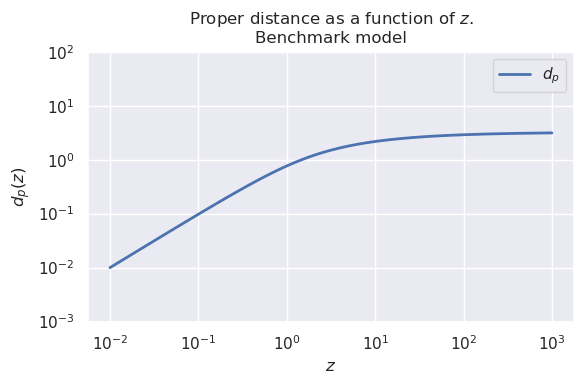

In [25]:
# Proper distance evolution as a function of redshift (log-log scale)
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(df_distance['z'], df_distance['d_p'], label = '$d_p$', linestyle = 'solid', linewidth = 2,  zorder = 100)

ax.set_xlabel('$z$')
ax.set_ylabel('$d_p(z)$')
ax.set_title('Proper distance as a function of $z$.\nBenchmark model')
plt.xscale('log')
plt.yscale('log')
ax.set_ylim(0.001, 100)
plt.legend()

plt.tight_layout()
plt.savefig('./figs/proper_distance_logz.png', dpi = 300)
plt.show()
plt.close(fig)

In [26]:
df_distance['d_l'] = df_distance['d_p']*(1+df_distance['z']) # Compute luminosity distance
df_distance['d_a'] = df_distance['d_l']/(1+df_distance['z'])**2 # Compute angular diameter distance

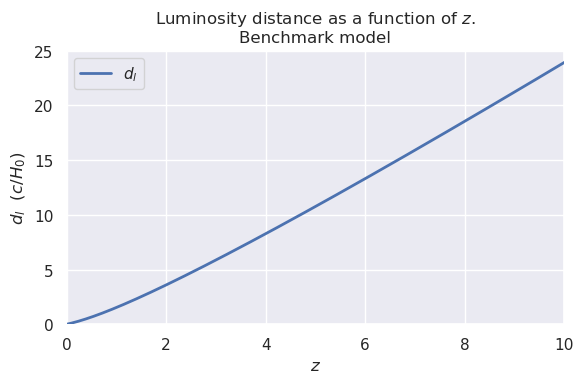

In [27]:
# Luminosity distance evolution as a function of redshift
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(df_distance['z'], df_distance['d_l'], label = '$d_l$', linestyle = 'solid', linewidth = 2,  zorder = 100)

ax.set_xlabel('$z$')
ax.set_ylabel('$d_l$  $(c/H_0)$')
ax.set_title('Luminosity distance as a function of $z$.\nBenchmark model')
ax.set_xlim(0, 10)
ax.set_ylim(0, 25)
plt.legend()

plt.tight_layout()
plt.savefig('./figs/luminosity_distance_z.png', dpi = 300)
plt.show()
plt.close(fig)

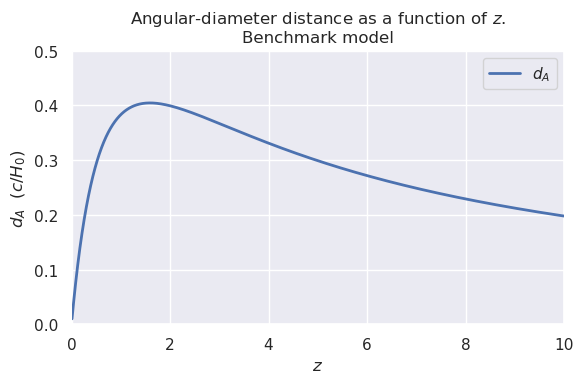

In [28]:
# Angular diameter distance evolution as a function of redshift
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(df_distance['z'], df_distance['d_a'], label = '$d_A$', linestyle = 'solid', linewidth = 2,  zorder = 100)

ax.set_xlabel('$z$')
ax.set_ylabel('$d_A$  $(c/H_0)$')
ax.set_title('Angular-diameter distance as a function of $z$.\nBenchmark model')
ax.set_xlim(0, 10)
ax.set_ylim(0, 0.5)
plt.legend()

plt.tight_layout()
plt.savefig('./figs/angular_distance_z.png', dpi = 300)
plt.show()
plt.close(fig)

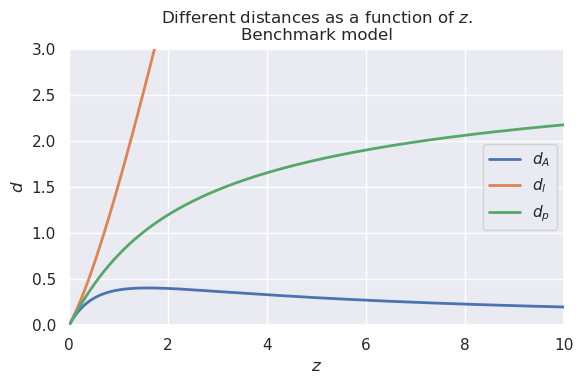

In [29]:
# Plot of distances as a function of redshift

fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(df_distance['z'], df_distance['d_a'], label = '$d_A$', linestyle = 'solid', linewidth = 2,  zorder = 100)
ax.plot(df_distance['z'], df_distance['d_l'], label = '$d_l$', linestyle = 'solid', linewidth = 2,  zorder = 100)
ax.plot(df_distance['z'], df_distance['d_p'], label = '$d_p$', linestyle = 'solid', linewidth = 2,  zorder = 100)

ax.set_xlabel('$z$')
ax.set_ylabel('$d$')
ax.set_title('Different distances as a function of $z$.\nBenchmark model')
ax.set_xlim(0, 10)
ax.set_ylim(0, 3)
plt.legend()

plt.tight_layout()
plt.savefig('./figs/distances_z.png', dpi = 300)
plt.show()
plt.close(fig)

## Point 4.

In particular use the Luminosity distance to compute the distance modulus

$$\mu = 5log_{10}{\frac{d_L}{1Mpc} + 25}$$

and compare it against the data provided.

In [30]:
df_distance['mu'] = 5*np.log10(df_distance['d_l']*c/H_0) + 25 # Compute distance modulus

In [31]:
# Load and clean up supernova data
import requests

response = requests.get('https://supernova.lbl.gov/Union/figures/SCPUnion_mu_vs_z.txt')
data = response.text
data = data.split('\n')[4:]

data = [float(value) for line in data for value in line.split('\t')[1:]]
data = np.array(data)
data = data.reshape(len(data)//3, 3)

In [32]:
df_supernova = pd.DataFrame(data, columns = ['z', 'mu', 'mu_err']) # Dataframe of supernova data
df_aux = df_distance[(df_distance['z'] > 0.00) & (df_distance['z'] < 2)] # Filter out high redshifts

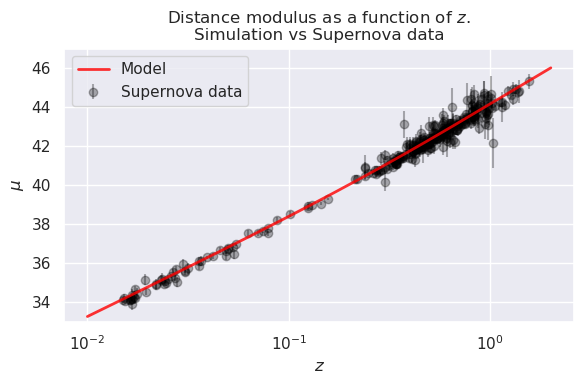

In [33]:
# Plot of distance modulus as a function of redshift (model vs. supernova data, log scale)
fig, ax = plt.subplots(figsize = (6, 4))

ax.errorbar(df_supernova['z'], df_supernova['mu'], df_supernova['mu_err'],
            label = 'Supernova data', color = 'black',
            fmt = 'o', zorder = 10, alpha = 0.3)

ax.plot(df_aux['z'], df_aux['mu'], label = 'Model', linestyle = 'solid',
        linewidth = 2,  zorder = 100, color = 'red', alpha = 0.8)
ax.set_xlabel('$z$')
ax.set_ylabel('$\mu$')
ax.set_title('Distance modulus as a function of $z$.\nSimulation vs Supernova data')
#ax.set_xlim(-0.05, 1.65)
ax.set_ylim(33, 47)
plt.xscale('log')
plt.legend()

plt.tight_layout()
plt.savefig('./figs/supernova_log.png', dpi = 300)
plt.show()
plt.close(fig)

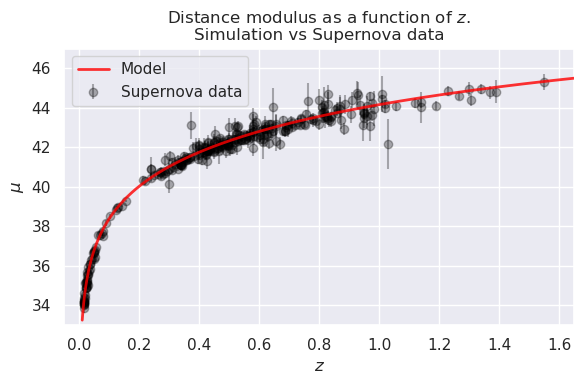

In [34]:
# Plot of distance modulus as a function of redshift (model vs. supernova data, linear scale)
fig, ax = plt.subplots(figsize = (6, 4))

ax.errorbar(df_supernova['z'], df_supernova['mu'], df_supernova['mu_err'],
            label = 'Supernova data', color = 'black',
            fmt = 'o', zorder = 10, alpha = 0.3)

ax.plot(df_aux['z'], df_aux['mu'], label = 'Model', linestyle = 'solid',
        linewidth = 2,  zorder = 100, color = 'red', alpha = 0.8)
ax.set_xlabel('$z$')
ax.set_ylabel('$\mu$')
ax.set_title('Distance modulus as a function of $z$.\nSimulation vs Supernova data')
ax.set_xlim(-0.05, 1.65)
ax.set_ylim(33, 47)
plt.legend()

plt.tight_layout()
plt.savefig('./figs/supernova_linear.png', dpi = 300)
plt.show()
plt.close(fig)